# IMPORTING ALL THE NEEDED LIBRARIES AND THE DATASET

In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


In [2]:
# Importing the dataset using pandas

df = pd.read_csv('/Users/siddhesh/Downloads/train_qnU1GcL.csv')
df = df.drop(['id'],axis=1)


# EXPLORATORY DATA ANALYSIS

In [3]:
df.describe()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,target
count,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000
mean,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,0.937410
std,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,0.242226
min,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,0.000000
25%,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,1.000000
50%,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,1.000000
75%,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,1.000000
max,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 11 columns):
perc_premium_paid_by_cash_credit    79853 non-null float64
age_in_days                         79853 non-null int64
Income                              79853 non-null int64
Count_3-6_months_late               79756 non-null float64
Count_6-12_months_late              79756 non-null float64
Count_more_than_12_months_late      79756 non-null float64
application_underwriting_score      76879 non-null float64
no_of_premiums_paid                 79853 non-null int64
sourcing_channel                    79853 non-null object
residence_area_type                 79853 non-null object
target                              79853 non-null int64
dtypes: float64(5), int64(4), object(2)
memory usage: 6.7+ MB


In [5]:
# As you can observe there are quite a few null values in the columns of Count_3-6_months_late,
# Count_6-12_months_late, Count_more_than_12_months_late and application_underwriting_score

count_nan = len(df) - df.count()
count_nan

perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 97
Count_6-12_months_late                97
Count_more_than_12_months_late        97
application_underwriting_score      2974
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
target                                 0
dtype: int64

In [6]:
pd.crosstab(df.sourcing_channel, df.target).apply(lambda r: r/r.sum(), axis=1)

target,0,1
sourcing_channel,,
A,0.054458,0.945542
B,0.064559,0.935441
C,0.075006,0.924994
D,0.083874,0.916126
E,0.075534,0.924466


In [7]:
pd.crosstab(df.residence_area_type, df.target).apply(lambda r: r/r.sum(), axis=1)

target,0,1
residence_area_type,,
Rural,0.063088,0.936912
Urban,0.062263,0.937737


In [8]:
# Looking at the above tables it can be seen that for the feature: "sourcing_channel", each of the channels has a 
# distribution of 5-8% 0's and a 95-92% of 1's, which indicates there's no differentiating factor among different channels
# Same is the case with 'residence_area_type'(with a 6% 0's and 93% 1's in both urban and rural types)
# While this reason is not sufficient enough to drop those features, because this test only portrays their
# independent contribution towards explaining the independent variable, but it's a start nonetheless

# Further down in the code i have used the selectk method to find out how significant certain features are, and it was
# found that these features have very less significance when compared to others

"""Usign the selectk method to estimate feature importance

y = df['target']
X = df.drop(['target'],axis=1)

selector = SelectKBest(chi2, k='all')
selector.fit(X, y)
X_new = selector.transform(X)
X.columns[selector.get_support(indices=True)].tolist()

# Output :-

['perc_premium_paid_by_cash_credit',
 'age_in_days',
 'Income',
 'Count_3-6_months_late',
 'Count_6-12_months_late',
 'Count_more_than_12_months_late',
 'application_underwriting_score',
 'no_of_premiums_paid',
 'channel_A',
 'channel_B',
 'channel_C',
 'channel_D',
 'area_Rural']"""


"Usign the selectk method to estimate feature importance\n\ny = df['target']\nX = df.drop(['target'],axis=1)\n\nselector = SelectKBest(chi2, k='all')\nselector.fit(X, y)\nX_new = selector.transform(X)\nX.columns[selector.get_support(indices=True)].tolist()\n\n# Output :-\n\n['perc_premium_paid_by_cash_credit',\n 'age_in_days',\n 'Income',\n 'Count_3-6_months_late',\n 'Count_6-12_months_late',\n 'Count_more_than_12_months_late',\n 'application_underwriting_score',\n 'no_of_premiums_paid',\n 'channel_A',\n 'channel_B',\n 'channel_C',\n 'channel_D',\n 'area_Rural']"

In [9]:
# Taking care of categorical features

df = pd.concat([df,pd.get_dummies(df['sourcing_channel'], prefix='channel')],axis=1)
df.drop(['sourcing_channel'],axis=1, inplace=True)
df.drop(['channel_E'],axis=1, inplace=True)

df = pd.concat([df,pd.get_dummies(df['residence_area_type'], prefix='area')],axis=1)
df.drop(['residence_area_type'],axis=1, inplace=True)
df.drop(['area_Urban'],axis=1, inplace=True)


In [10]:
# Some feature scaling 

df['age_in_days'] /= 365 
#df.age_in_days = df.age_in_days.round().astype(int)
df['perc_premium_paid_by_cash_credit'] *= 100
df['Income'] /= 10000 
#df.Income = df.Income.round().astype(int)


"""min_max_scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.MinMaxScaler()

df_scaled = min_max_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled)

my_columns = df.columns
df_scaled.columns = my_columns"""

# Note that i also tried to do it using the minmax scaling technique, but it didn't fetch me any better results
# So i decided to carry on with the manual method dividing and multiplying the whole columns with scalar values for
# the sake of simplicity

'min_max_scaler = preprocessing.MinMaxScaler()\nscaler = preprocessing.MinMaxScaler()\n\ndf_scaled = min_max_scaler.fit_transform(df)\ndf_scaled = pd.DataFrame(df_scaled)\n\nmy_columns = df.columns\ndf_scaled.columns = my_columns'

In [11]:
# My initial approach to deal with missing values was to just fill the null values with 0s and mean of the columns,
# but as the dataset was explored further it revelaed that these 4 features were the most important ones, 
# so I thought it wouldn't be a good idea to just fill the missing values with 0s and means as it may lead to 
# loss of important info so I decided to use the KNN imputer method to handle the missing values 

"""df['application_underwriting_score'].fillna((df['application_underwriting_score'].mean()), inplace=True)
df['Count_3-6_months_late'].fillna((0), inplace=True)
df['Count_6-12_months_late'].fillna((0), inplace=True)
df['Count_more_than_12_months_late'].fillna((0), inplace=True)"""

my_columns = df.columns
imputer = KNNImputer(n_neighbors = 1)
df = imputer.fit_transform(df)
df = pd.DataFrame(data=df,columns=my_columns)


In [12]:
# Making sure there are no null values left 

count_nan = len(df) - df.count()
count_nan

perc_premium_paid_by_cash_credit    0
age_in_days                         0
Income                              0
Count_3-6_months_late               0
Count_6-12_months_late              0
Count_more_than_12_months_late      0
application_underwriting_score      0
no_of_premiums_paid                 0
target                              0
channel_A                           0
channel_B                           0
channel_C                           0
channel_D                           0
area_Rural                          0
dtype: int64

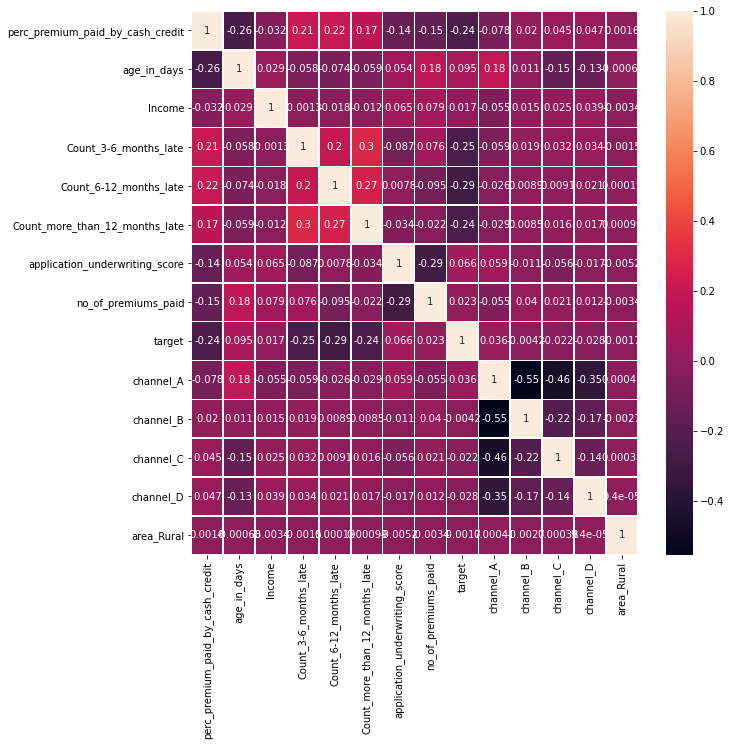

In [13]:
# Plotting a heatmap to get an idea about the correlation of features with the target variable

dfcorr = df.corr()

fig, ax = plt.subplots(figsize=(10,10))       
sns.heatmap(dfcorr, annot=True, linewidths=.5, ax=ax)


In [14]:
# As we can see this is quite an unbalanced dataset, I had tried to use SMOTE, but it didn't fetch me any better 
# results so I didn't include it in the solution

df['target'].value_counts()

1.0    74855
0.0     4998
Name: target, dtype: int64

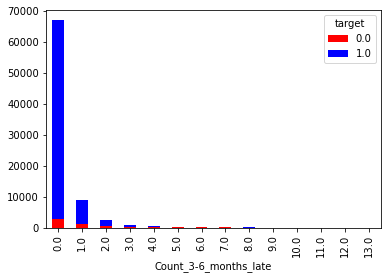

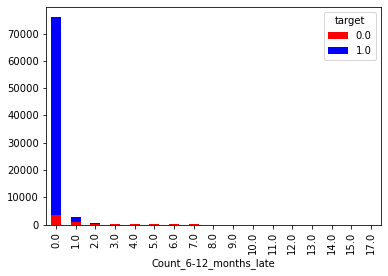

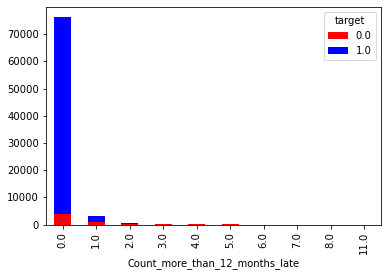

In [15]:
temp1 = pd.crosstab(df['Count_3-6_months_late'], df['target'])
temp1.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

temp2 = pd.crosstab(df['Count_6-12_months_late'], df['target'])
temp2.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

temp3 = pd.crosstab(df['Count_more_than_12_months_late'], df['target'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

In [16]:
# Saving the processed dataset

df.to_csv('new_train.csv', index=False)

In [17]:
# Making a train-test split

df = pd.read_csv('new_train.csv')  

y = df['target']
X = df.drop(['target'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 0)

# XGBOOST

In [18]:
regressor= xgb.XGBRegressor(learning_rate=0.1, n_estimators=184, max_depth=4, objective='binary:logistic',gamma=6,
                        min_child_weight=5, nthread=5, random_state=27, subsample=0.5, colsample_bytree=0.9)

regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_test)


/Users/siddhesh/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


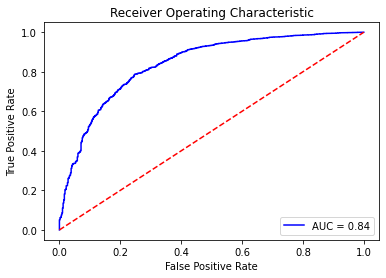

In [19]:
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

buildROC(y_test,y_pred)

# TEST

In [20]:
# The entire process of feature engineering repeated on the test set(and more importantly..
# in the same order as done on the training data)
# i.e 1) drop 'id', 2) get_dummies() over source and residence, 3) feature scaling and 4) knn imputation for nulls

df = pd.read_csv('/Users/siddhesh/Downloads/test_LxCaReE_DvdCKVT2_7rMflxW_O46whsi_lVTFXAY_YMoDwli.csv')

ids = df['id']
df = df.drop(['id'],axis=1)

df = pd.concat([df,pd.get_dummies(df['sourcing_channel'], prefix='channel')],axis=1)
df.drop(['sourcing_channel'], axis=1, inplace=True)
df.drop(['channel_E'], axis=1, inplace=True)

df = pd.concat([df,pd.get_dummies(df['residence_area_type'], prefix='area')],axis=1)
df.drop(['residence_area_type'], axis=1, inplace=True)
df.drop(['area_Urban'], axis=1, inplace=True)

df['age_in_days'] /= 365 
#df.age_in_days = df.age_in_days.round().astype(int)
df['perc_premium_paid_by_cash_credit'] *= 100
df['Income'] /= 10000 
#df.Income = df.Income.round().astype(int) 

my_columns = df.columns
imputer = KNNImputer(n_neighbors= 1)
df = imputer.fit_transform(df)
df = pd.DataFrame(data=df,columns=my_columns)

df.to_csv('new_test.csv', index=False)


In [21]:
df = pd.read_csv('new_test.csv')

ypred = regressor.predict(df)
solution = {'id': ids, 'target': ypred}
solution = pd.DataFrame(data=solution)
solution.to_csv('solution.csv', index=False)

# the result 0.8513

# LGBM

/Users/siddhesh/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 67362, number of negative: 4505
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1081
[LightGBM] [Info] Number of data points in the train set: 71867, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.937315 -> initscore=2.704893
[LightGBM] [Info] Start training from score 2.704893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.779815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.823688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.827233
[4]	valid_0's auc: 0.827078
[5]	valid_0's auc: 0.830373
[6]	valid_0's auc: 0.83016
[7]	valid_0's auc: 0.830205
[8]	valid_0's auc: 0.8

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[114]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[115]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[116]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[117]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

[153]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[154]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[155]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[156]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[157]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[247]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[248]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[249]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[250]	valid_0's auc: 0.823554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[251]	valid_0's auc: 0.823554
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[300]	valid_0's auc: 0.823554


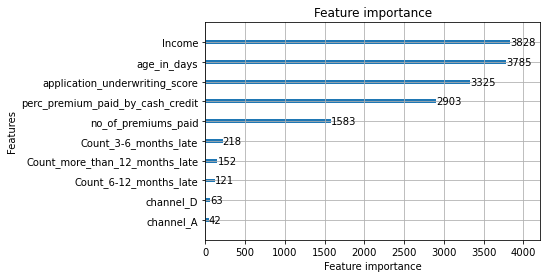

In [22]:
parameters = {'learning_rate': 0.1, 'boosting': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_estimators':300,
    'reg_lambda':1.1, 'reg_alpha':1.2, 'num_leaves':250, 'min_split_gain':0.3, 'max_depth': 15, 'subsample': 0.9,  
    'subsample_freq': 20, 'colsample_bytree': 0.7}

model = lgb.train(params = parameters, train_set= lgb.Dataset(X_train, label=y_train.values),
                  valid_sets = lgb.Dataset(X_test, label=y_test.values))

valid_pred = model.predict(X_test)

ax = lgb.plot_importance(model, max_num_features=10)
plt.show()

In [24]:
# BEST MODEL:-
#XGBRegressor(learning_rate=0.1, n_estimators=184, max_depth=4, objective='binary:logistic',gamma=6,
#                       min_child_weight=5, nthread=5, random_state=27, subsample=0.5, colsample_bytree=0.9)

# BEST SCORE :-
0.8513

0.8513